In [0]:
# activate R magic
import rpy2
%load_ext rpy2.ipython

In [2]:
%%R

library(rvest)
library(jsonlite)
library(lubridate) # ymd
library(dplyr) # group_by
library(tidyr) #complete

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: xml2

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘lubridate’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following object is masked from ‘package:base’:

    date


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are mask

In [3]:
%%R

#Generic collector
getMarketData <- function(marketName, tickInterval="day"){
  temp_url <- paste0("https://international.bittrex.com/Api/v2.0/pub/market/GetTicks?_=1499127220008&marketName=",marketName,"&tickInterval=",tickInterval)
  webpage <- fromJSON(temp_url)
  df <- webpage$result
  df$MarketName <- marketName
  return(df)
}

top50BTCMarkets <- c("BTC-ETH","BTC-XRP","BTC-LTC","BTC-XLM","USDT-BTC")
tickList <- c("oneMin","fiveMin", "thirtyMin", "hour","day")
marketPrices <- getMarketData(top50BTCMarkets[1], tickList[5])

for (i in 2:length(top50BTCMarkets)) {
  tempDF <- getMarketData(top50BTCMarkets[i], tickList[5])
  marketPrices <- rbind(marketPrices, tempDF)
  tempDF <- NULL
}

#Save Data
marketPrices$T <- as.Date(marketPrices$T)
marketPrices$MarketName <- as.factor(marketPrices$MarketName)

#Preprocess
df <- marketPrices
#Calculate the period-over-period percentage change at each point in time
percentageCalc <- function(marketName){
  marketData <- df[df$MarketName==marketName,]
  #Open, Closed, High, Low, Volume, BaseVolume
  data <- marketData[,c("O","C","H","L","V","BV")]
  data$Mean <- (data$H + data$L)/2
  newdf <- (tail(data, -1) - head(data, -1))/data[-nrow(data),]
  newdf$T <- tail(marketData$T, -1)
  newdf$MarketName <- marketName
  newdf$Reward <- newdf$Mean*100
  return(newdf)
}

list_of_dataframes <- lapply(unique(df$MarketName), function(x) percentageCalc(x))
prepData <- bind_rows(list_of_dataframes, .id = "ID")

#Simplify data to quick test
# We will only use ETH, LTC, XRP, XLM, USDT for BTC market as Multi-armed bandit approach
baseMarkets <- c("BTC-ETH", "BTC-LTC", "BTC-XRP", "BTC-XLM", "USDT-BTC")
baseData <- prepData[prepData$MarketName %in% baseMarkets,]
# ETH -> "2015-08-15"
# LTC -> "2014-03-10"
# XRP -> "2014-12-23"
# XLM -> "2015-11-19"
# USDT -> "2015-12-15"
# So we take "2015-12-15" as min date to arbitrage test
baseData <- baseData[baseData$T >= "2015-12-15",]
#Fill missing
USDData <- baseData[baseData$MarketName=="USDT-BTC",] %>%
  mutate(T = as.Date(T)) %>%
  complete(T = seq.Date(min(T), max(T), by="day")) %>%
  #group_by(ID, MarketName) %>%
  fill(ID,MarketName,O,C,H,L,V,BV,Mean,Reward)

XLMData <- baseData[baseData$MarketName=="BTC-XLM",] %>%
  mutate(T = as.Date(T)) %>%
  complete(T = seq.Date(min(T), max(T), by="day")) %>%
  #group_by(ID, MarketName) %>%
  fill(ID,MarketName,O,C,H,L,V,BV,Mean,Reward)

#Merge all in a bundle
trainData <- baseData[baseData$MarketName!="USDT-BTC",]
trainData <- trainData[trainData$MarketName!="BTC-XLM",]
trainData <- rbind(trainData, XLMData, USDData)

#1235 day for each asset
write.csv(trainData, file = "trainData.csv", row.names = F)
print(head(trainData))

    ID            O            C            H           L          V         BV
123  1  0.015274862 -0.023043646 -0.002149552 -0.01617426  0.4190061  0.4118777
124  1 -0.036503037  0.001192329  0.040730081 -0.03283849  0.5005542  0.4853577
125  1  0.015462728 -0.063636364 -0.078651124 -0.04816364 -0.3948358 -0.4235019
126  1 -0.063636364 -0.041747573 -0.068825545 -0.00505553 -0.4075741 -0.4372437
127  1 -0.041747573 -0.009620061 -0.030635922 -0.03287817  0.1059601  0.0926574
128  1 -0.009620061  0.038869366  0.099274372  0.02612808  0.2579297  0.3257258
            Mean          T MarketName     Reward
123 -0.008965609 2015-12-15    BTC-ETH -0.8965609
124  0.005235567 2015-12-16    BTC-ETH  0.5235567
125 -0.064498997 2015-12-17    BTC-ETH -6.4498997
126 -0.038706954 2015-12-18    BTC-ETH -3.8706954
127 -0.031732010 2015-12-19    BTC-ETH -3.1732010
128  0.063560321 2015-12-20    BTC-ETH  6.3560321


In [5]:
#Read training data
import pandas as pd
fileName = "trainData.csv"
df = pd.read_csv(fileName, sep = ',')
df.head()

,ID,O,C,H,L,V,BV,Mean,T,MarketName,Reward
0,1,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878,-0.008966,2015-12-15,BTC-ETH,-0.896561
1,1,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358,0.005236,2015-12-16,BTC-ETH,0.523557
2,1,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502,-0.064499,2015-12-17,BTC-ETH,-6.449900
3,1,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244,-0.038707,2015-12-18,BTC-ETH,-3.870695
4,1,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657,-0.031732,2015-12-19,BTC-ETH,-3.173201


In [0]:
colnames = ['T','O','C','H','L','V','BV']
reward_cols = ['T','Reward']

In [7]:
eth = df[(df['MarketName'] == 'BTC-ETH')][colnames]
xrp = df[(df['MarketName'] == 'BTC-XRP')][colnames]
ltc = df[(df['MarketName'] == 'BTC-LTC')][colnames]
xlm = df[(df['MarketName'] == 'BTC-XLM')][colnames]
usd = df[(df['MarketName'] == 'USDT-BTC')][colnames]

eth.head()

,T,O,C,H,L,V,BV
0,2015-12-15,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878
1,2015-12-16,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358
2,2015-12-17,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502
3,2015-12-18,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244
4,2015-12-19,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657


In [8]:
eth_reward = df[(df['MarketName'] == 'BTC-ETH')][reward_cols]
xrp_reward = df[(df['MarketName'] == 'BTC-XRP')][reward_cols]
ltc_reward = df[(df['MarketName'] == 'BTC-LTC')][reward_cols]
xlm_reward = df[(df['MarketName'] == 'BTC-XLM')][reward_cols]
usd_reward = df[(df['MarketName'] == 'USDT-BTC')][reward_cols]
usd_reward.loc[:,'Reward'] *= -1 # Because we used tether reward


eth_reward.head()

,T,Reward
0,2015-12-15,-0.896561
1,2015-12-16,0.523557
2,2015-12-17,-6.449900
3,2015-12-18,-3.870695
4,2015-12-19,-3.173201


In [9]:
merged1 = pd.merge(eth, xrp, on = 'T', suffixes=('_eth', '_xrp'))
merged2 = pd.merge(ltc, xlm, on = 'T', suffixes=('_ltc', '_xlm'))
merged = pd.merge(merged1, merged2, on = 'T')
merged = pd.merge(merged, usd, on = 'T')
merged.head()

,T,O_eth,C_eth,H_eth,L_eth,V_eth,BV_eth,O_xrp,C_xrp,H_xrp,L_xrp,V_xrp,BV_xrp,O_ltc,C_ltc,H_ltc,L_ltc,V_ltc,BV_ltc,O_xlm,C_xlm,H_xlm,L_xlm,V_xlm,BV_xlm,O,C,H,L,V,BV
0,2015-12-15,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878,-0.250256,-0.100416,-0.212046,-0.168975,1.418301,0.897542,-0.018060,0.012889,0.011777,-0.009781,0.838961,0.849676,-0.043933,-0.144351,-0.043933,-0.144351,1029.180334,885.502597,0.000000,0.071429,0.071429,0.000000,1320.637261,1410.396749
1,2015-12-16,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358,-0.111491,0.131640,-0.027795,0.052500,-0.799042,-0.782534,0.011609,-0.017773,-0.009005,0.002394,-0.295003,-0.300707,-0.091904,0.000000,-0.052516,0.000000,-0.521941,-0.507073,0.071429,0.002222,0.044444,0.071429,-0.815032,-0.810448
2,2015-12-17,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502,0.131640,-0.024490,-0.025341,0.127474,-0.613285,-0.605696,-0.016522,0.026429,0.007796,0.007197,-0.238974,-0.232854,-0.014458,0.000000,-0.055427,0.000000,-0.992587,-0.992851,0.071429,0.002222,0.044444,0.071429,-0.815032,-0.810448
3,2015-12-18,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244,-0.040816,-0.056485,-0.054000,-0.096910,0.873151,0.705247,0.021972,-0.024771,-0.014549,0.001388,0.643869,0.634503,0.019560,0.058680,0.058680,0.019560,1.314162,1.401100,0.020000,0.017738,-0.023404,0.020000,-0.999841,-0.999841
4,2015-12-19,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657,-0.036879,-0.002956,-0.038055,0.031104,-0.903999,-0.902755,-0.020528,0.003278,-0.016248,-0.002521,-0.855318,-0.856800,-0.016787,-0.131640,-0.053118,-0.098321,11.826813,10.635375,-0.017429,-0.017429,-0.017429,-0.017429,863.027096,847.967800


#REINFORCEMENT LEARNING SETTINGS



In [10]:
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.preprocessing import MinMaxScaler
from random import randint

Using TensorFlow backend.


In [0]:
EPISODES = 2

class TradingAction(object):
    ETH = 0
    XRP = 1
    LTC = 2
    XLM = 3
    USD = 4
    BTC = 5
    
class TradingEnv:
  def __init__(self):
    #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
    pass

  def reset(self):
    pass

  def __init__(self):
    #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
    pass

  def step(self, action, date):
    reward = 0
    if action == TradingAction.ETH:
        reward = eth_reward[(eth_reward['T'] == date)]['Reward']
    if action == TradingAction.XRP:
        reward = xrp_reward[(xrp_reward['T'] == date)]['Reward']
    if action == TradingAction.LTC:
        reward = ltc_reward[(ltc_reward['T'] == date)]['Reward']
    if action == TradingAction.XLM:
        reward = xlm_reward[(xlm_reward['T'] == date)]['Reward']
    if action == TradingAction.USD:
        reward = usd_reward[(usd_reward['T'] == date)]['Reward']
    if action == TradingAction.BTC:
        reward = 0 # Do nothing action
    return reward

In [0]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            '''
            if not done:
                temp_pred = np.amax(self.model.predict(next_state)[0])
                target = (reward + self.gamma * temp_pred)
                target = target.item()
            '''
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [13]:
#Split as Train and Test data
row_count = merged.shape[0]
split_point = int(row_count - 60)
train_data, test_data = merged[:split_point], merged[split_point:]
test_data.head()

,T,O_eth,C_eth,H_eth,L_eth,V_eth,BV_eth,O_xrp,C_xrp,H_xrp,L_xrp,V_xrp,BV_xrp,O_ltc,C_ltc,H_ltc,L_ltc,V_ltc,BV_ltc,O_xlm,C_xlm,H_xlm,L_xlm,V_xlm,BV_xlm,O,C,H,L,V,BV
1190,2019-03-19,-0.008638,-0.000860,-0.010302,0.000862,-0.242948,-0.247808,-0.005050,-0.002156,-0.006422,0.000383,-0.317247,-0.319710,-0.023772,-0.004038,-0.034031,-0.008883,0.845244,0.820885,0.065154,-0.041524,-0.001681,0.034431,-0.426080,-0.424562,0.001601,0.004968,0.000365,0.003223,-0.426543,-0.424743
1191,2019-03-20,-0.000039,-0.003951,-0.008330,-0.008638,-0.063724,-0.068058,-0.001903,-0.001144,0.012546,-0.006378,1.284100,1.286391,-0.001230,0.005462,0.003359,-0.013781,-0.673455,-0.671795,-0.040206,-0.035804,-0.053872,-0.028582,-0.321484,-0.342432,0.006122,0.007443,0.003994,0.003877,0.153287,0.159204
1192,2019-03-21,-0.004292,-0.015139,-0.002748,-0.011451,0.323505,0.315041,-0.000890,-0.010308,-0.013517,-0.012709,-0.288492,-0.296344,0.005473,-0.011056,-0.003856,0.014714,0.209315,0.202057,-0.036520,-0.014853,-0.032028,-0.051024,-0.022323,-0.063149,0.006040,-0.015198,0.002972,-0.018895,0.765888,0.755553
1193,2019-03-22,-0.014801,0.007919,-0.004498,-0.000200,-0.207166,-0.209078,-0.010434,0.000000,-0.008627,0.001300,-0.320643,-0.322993,-0.012562,0.008445,-0.004275,0.002775,0.978521,0.977366,-0.014864,0.021108,0.009926,0.029042,-0.383236,-0.371657,-0.014622,0.001982,-0.013914,0.014609,-0.455185,-0.455566
1194,2019-03-23,0.007276,0.003864,0.004777,0.009597,-0.236036,-0.232347,0.000129,0.000386,0.000256,0.006103,0.122010,0.123417,0.009973,0.021783,0.029809,0.013190,-0.652752,-0.642759,0.023765,-0.015135,-0.005825,0.011060,-0.086430,-0.088340,0.002648,0.003766,0.004866,0.001829,-0.350675,-0.349206


In [0]:
#Preprocess Data
scaler = MinMaxScaler()
scaled_cols = ['O_eth','C_eth','H_eth','L_eth','V_eth','BV_eth','O_xrp','C_xrp','H_xrp','L_xrp','V_xrp','BV_xrp','O_ltc','C_ltc','H_ltc','L_ltc','V_ltc','BV_ltc','O_xlm','C_xlm','H_xlm','L_xlm','V_xlm','BV_xlm','O','C','H','L','V','BV']
scaler.fit(train_data[scaled_cols])
train_data.iloc[:][scaled_cols] = scaler.transform(train_data[scaled_cols])
#Use same scaler to transform test data
test_data.iloc[:][scaled_cols] = scaler.transform(test_data[scaled_cols])

In [20]:
#TRAIN AGENT
observation_cols = ['O_eth','C_eth','H_eth','L_eth','V_eth','BV_eth','O_xrp','C_xrp','H_xrp','L_xrp','V_xrp','BV_xrp','O_ltc','C_ltc','H_ltc','L_ltc','V_ltc','BV_ltc','O_xlm','C_xlm','H_xlm','L_xlm','V_xlm','BV_xlm','O','C','H','L','V','BV']
state_size = len(observation_cols)
action_size = 6 #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
env = TradingEnv()
agent = DQNAgent(state_size, action_size)
# agent.load("./save/trading-dqn.h5")

done = False
batch_size = 32
best_score = 0
best_action = 0
best_reward = -100000

for e in range(EPISODES):
    total_reward = 0
    for idx in range(len(train_data)-1):
        state = train_data.iloc[idx][observation_cols]
        state = np.reshape([state], [1, state_size])
        
        action = agent.act(state)
        reward = env.step(action, train_data.iloc[idx+1]['T'])
        
        next_state = train_data.iloc[idx+1][observation_cols]
        next_state = np.reshape([next_state], [1, state_size])
        
        if isinstance(reward, int) == False:
            reward = reward.item()
            
        agent.remember(state, action, reward, next_state, done)
        total_reward = total_reward + reward
        if total_reward >= best_reward:
            best_reward = total_reward
            best_action = action
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    print("episode: {}, best_reward: {}, total_reward: {}" .format(e, best_reward, total_reward))

episode: 0, best_reward: 856.1081790128247, total_reward: 854.8411469310073
episode: 1, best_reward: 2089.608907228063, total_reward: 2089.608907228063


In [0]:
#Save Agent
#agent.save("./save/trading-dqn.h5")

In [21]:
#TEST AGENT
done = False
batch_size = 32
test_reward = 0
reward_list = []
for idx in range(len(test_data)-1):
    state = test_data.iloc[idx][observation_cols]
    state = np.reshape([state], [1, state_size])

    action = agent.act(state)
    reward = env.step(action, test_data.iloc[idx+1]['T'])
    if isinstance(reward, int) == False:
        reward = reward.item()
    test_reward = test_reward + reward 
    reward_list.append(reward)
print("Test_reward: {}" .format(test_reward))

Test_reward: -11.351140638386518


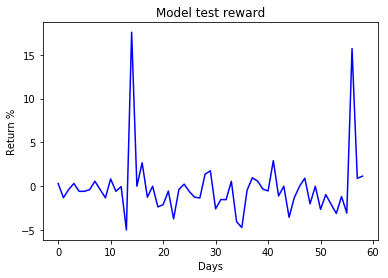

In [22]:
#Plot rewards
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(0,len(test_data)-1,1),reward_list, c='b')
plt.title('Model test reward')
plt.ylabel('Return %')
plt.xlabel('Days')
plt.show()

In [23]:
index = -2
print(merged.iloc[index]['T'])
state = merged.iloc[index][observation_cols]
state = np.reshape([state], [1, state_size])
act_values = agent.model.predict(state)
print(act_values)
print("Best action",np.argmax(act_values[0]))
print("Best reward",np.max(act_values[0]))
#Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc

2019-05-16
[[  8.913004   -20.9641      -4.5284405    5.869917    -0.57533765
   -0.24602652]]
Best action 0
Best reward 8.913004


In [24]:
index = -1
print(eth_reward.iloc[index]['T'])
r1 = eth_reward.iloc[index]['Reward'].item()
r2 = xrp_reward.iloc[index]['Reward'].item()
r3 = ltc_reward.iloc[index]['Reward'].item()
r4 = xlm_reward.iloc[index]['Reward'].item()
r5 = usd_reward.iloc[index]['Reward'].item()
print("eth: {}, xrp: {}, ltc: {}, xlm: {}, usd: {}, btc: {}" .format(r1, r2, r3, r4, r5, 0))

2019-05-17
eth: 1.1511711702589098, xrp: -4.0062626634739305, ltc: -0.8117926408226178, xlm: -5.76289791437979, usd: 6.90661447150133, btc: 0
